# The fundamentals of sample rate conversion

**Learning goals:**
* Experiencing the effects of interpolation and decimation on the frequency content of a signal
* Understanding the role of filters in sample rate conversion

**Relevant reading:**
* Chapters 10.1 - 10.6 in the book "Understanding Digital Signal Processing"

**Libraries and notebook config:**

In [96]:
from scipy.io import wavfile
import scipy.signal as sig
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

%matplotlib inline

### Introduction

In a number of situations, it is desirable to convert a digital signal $x_{\text{old}}[n]$ acquired at sampling frequency $f_{s, \text{ old}}$ to a new sampling frequency $f_{s, \text{ new}}$, producing a new signal $x_{\text{new}}[m]$. The reasons for doing this might be comparing streams of data with different sample rates, or reducing the sample rate of a signal which was initially [oversampled](https://en.wikipedia.org/wiki/Oversampling). Given that both $x_{\text{old}}[n]$ and $x_{\text{new}}[m]$ are a discrete-time representation of the same analog signal $x(t)$, the ideal result is for the signal $x_{\text{new}}[m]$ to be an exact discrete-time representation of $x(t)$ (assuming the nyquist criterion is met with the new sampling frequency $f_{s, \text{ new}}$):
$$x_{\text{new}}[m] = x(t) \bigg|_{t = \frac{m}{f_{s, \text{ new}}}}$$


### Problem description

Given a continuous-time signal $x(t)$ which has the following frequency content: 
$$X(\omega) = \begin{cases}1 - \frac{|f|}{40}, & -40\text{ Hz} < f < 40\text{ Hz} \\ 0 ,& \text{otherwise} \end{cases}$$

The signal $x(t)$ is sampled with a initial sampling rate $f_s = 100 \text{ Hz}$, to produce a discrete-time signal $x[n]$. The sampled signal $x[n]$ is recorded in the file `task1_signal.mat` in the `data` folder. The code cell below will load the signal $x[n]$ into an array `x_n` as well as the initial sampling frequency $f_s$ into the variable `fs`, and use the matlab-function `magnitude_spectrum` to create a plot of the signal's frequency content.

100


Text(0.5, 1.0, "Magnitude spectrum of signal stored in 'task1_signal.mat'")

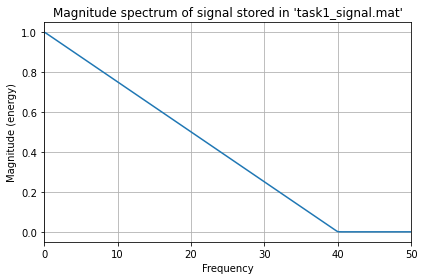

In [97]:
from scipy.io import loadmat
data = loadmat("data/task1_signal.mat", squeeze_me=True)
x_n = data["x_n"]
fs = data["fs"]

print(fs)

plt.magnitude_spectrum(x_n, Fs=fs);
plt.title("Magnitude spectrum of signal stored in 'task1_signal.mat'")

Throughout this problem we will explore how sample rate conversion can be performed on the signal $x[n]$, and what steps need to be taken to ensure the frequency content after sample rate conversion matches that seen in the plot above to the largest possible degree.


### Downsampling
The first component of sample rate conversion we will explore is Downsampling; the process of reducing the sample rate of a discrete signal $x_{\text{old}}[n]$ by a factor of $M$. Described mathematically, the downsampled signal $x_{\text{new}}[m]$ is a discrete-time signal where the new sampling frequency is 
$$f_{s, \text{ new}} = \frac{f_{s, \text{ old}}}{M}$$
Before we simply reduce the number of samples in a signal however, it is important to first remove any frequency components which reside above the *new* nyquist frequency $\frac{f_{s, \text{ new}}}{2}$. Otherwise, the high-frequency portions of the signal $x[n]$ will cause aliasing in the downsampled signal $x_{\text{new}}[m]$. To illustrate why this is necessary, let's see what happens when we decimate the signal $x[n]$ without filtering first...

## a)
* Create a new array of downsampled data by using **list slicing** to decimate the signal `x_n` by a factor of $2$, and display the magnitude spectrum of the decimated signal alongside the original signal. Mathematically, the decimated signal will given by the following equation:

$$x_{\text{new}}[m] = x[2\cdot m]$$


100


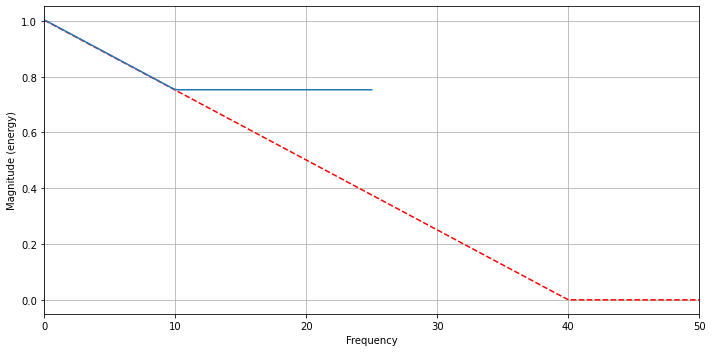

In [98]:
# WRITE YOUR CODE IN THIS CELL:
x_new = x_n[::2]

print(fs)

plt.close(1); plt.figure(1,figsize=(10,5))
plt.magnitude_spectrum(x_n, Fs=fs, color='r', linestyle='--');
plt.magnitude_spectrum(x_new, Fs=fs/2);

[Here](figures/task1a_lf.png) is an image showing what the end result should look like.

* Study the magnitude spectrum of the decimated signal `x_new`. What is going on in the frequency range $10\text{Hz}<f<25\text{Hz}$?

ANSWER THEORY QUESTIONS HERE:

The original signal had a Fs of 100hz, then a nyqvist frequency at 50hz. The new nyqvist frequency is then Fs_new/2 = Fs_old/2M, which is 100/2*2 = 25. Therefore we see an overlap between 10 to 25hz due to aliasing.


Now that we have observed the effects of directly decimating the signal $x[n]$, lets now insert a filter before the decimation, and see what effects this will have on the downsampled signal's frequency content.

## b)

* Use either the *window design method* or the function [remez](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.remez.html) to design a $257$-tap lowpass FIR filter with the transition region centered around $\hat{\omega}_c=\frac{\pi}{2}$. Then, filter the full-rate signal $x[n]$ using your lowpass filter **before** decimation. Once again, plot the magnitude spectrum of the downsampled signal $x_{\text{new}}[m]$ alongside the original signal $x[n]$. Use convolution `mode="same"` to ensure output length equals input length.

<!--*PS: Filtering the signal using convolution will result in a longer output than input, but with the same total signal energy. Matlab's `magnitude_spectrum` function divides by signal lenght $N$ to calculate the magnitde spectrum, meaning the filtered magnitude spectrum may appear weaker than the input magnitude spectrum. This can be corrected by scaling with $\frac{L_{\text{out}}}{L_{\text{in}}}$*.-->

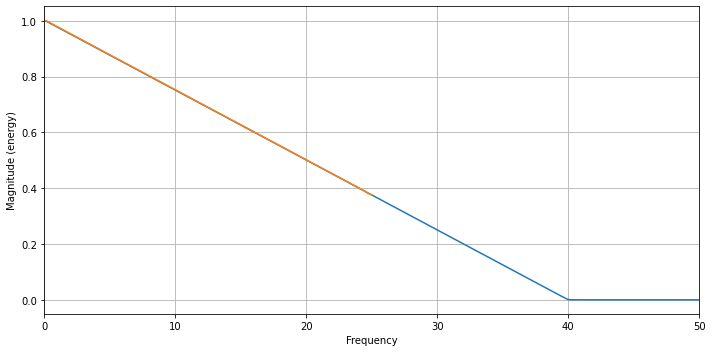

In [99]:
# WRITE YOUR CODE IN THIS CELL:

M = 2 # decimation factor
nTaps = 257 
D = (nTaps-1)/2
n = np.arange(nTaps)-D
wc = np.pi/2


hn = wc/np.pi*np.sinc(wc/np.pi*n)*sig.windows.hamming(nTaps) # Mitt filter
hn_f = 1/M*np.sinc(1/M*n)*sig.windows.hamming(nTaps) # Forelesning filter


#REMEZ
freq_band = [0, wc, wc + wc/10, 0.5*fs]
hn_remez = sig.remez(nTaps,freq_band, [1, 0], fs=fs)


yn = np.convolve(x_n,hn,mode="same") # Normal Convultion
yn_f = np.convolve(x_n,hn_f, mode="same")

L_y = len(x_n) + len(hn) - 1 # Fast convolution
Hm = np.fft.rfft(hn, L_y)
Xm = np.fft.rfft(x_new, L_y)
yn_1 = np.fft.irfft(Hm*Xm)

yn = yn[::2]
yn_f = yn_f[::2]
yn_1 = yn_1[::2]


plt.close(2); plt.figure(2,figsize=(10,5))
#plt.subplot(2,1,1)
plt.magnitude_spectrum(x_n,Fs=fs);
plt.magnitude_spectrum(yn,Fs=fs/2);
#plt.magnitude_spectrum(yn_f,Fs=fs/2, linestyle="--");
#plt.magnitude_spectrum(yn_1,Fs=fs/2);
#plt.subplot(2,1,2)
#plt.magnitude_spectrum(yn_1,Fs=fs/2);



[Here](figures/task1b_lf.png) is an image showing what the end result should look like. PS: don't worry too much if the magnitudes don't match exaclty, this is merely a scaling issue. The important part is that the *shape* of the downsampled magnitude spectrum is correct.

* Study the magnitude spectrum plot for $x_{\text{new}}[m]$ and $x[n]$. Explain why our current result would be more desirable as a output of a downsampling operation thant the result in task **a)**

ANSWER THEORY QUESTIONS HERE:

The new downsampled signal is more desirable because it more accuratly reflects the original signal. and doesnt overlap due to the aliasing

### Upsampling

The next component of sample rate conversion we will explore is Upsampling; the process of increasing the sample rate of a discrete signal $x_{\text{old}}[n]$ by a factor of $L$. Described mathematically, the upsampled signal $x_{\text{new}}[m]$ is a discrete-time signal where the new sampling frequency is 
$$f_{s, \text{ new}} = f_{s, \text{ old}} \cdot L$$

For upsampling to be successful, we need to estimate the value of the original analog signal $x(t)$ at points *between* the sampling times $t_n \in \{0, T_s, 2T_s, \ldots\}$. The term for this is [*interpolation*](https://en.wikipedia.org/wiki/Interpolation), and there exists many approaches to interpolation depending on the field.

From a signal processing perspective, the goal can be defined as follows: find the discrete-time signal $x_{\text{new}}[m]$ whose frequency-domain representation $X_{\text{new}}(\hat{\omega})$ is:

$$X_{\text{new}}(\hat{\omega}) \begin{cases} X_{\text{old}}(\hat{2\omega}), & 0 \leq \hat{\omega} \leq \frac{\pi}{2} \\ 0, & \frac{\pi}{2}  < \hat{\omega} \leq \pi \end{cases}$$


This is accomplished in two stages:
1. Interpolate the signal with $L-1$ zeroes between each sample. This will create a signal with high-frequency spectral images of $x(t)$
2. Use a lowpass filter to remove the spectral images, and amplify the frequencies in the frequency range $0 \leq f < \frac{f_{s, \text{ old}}}{2}$.

Let's take a closer look at the first stage, and what the frequency domain of a signal looks like if we interpolate by a factor of $L=2$...

## c)
* Use python to interpolate the signal $x[n]$ by a factor of $2$. The output should be a new array `x_new` with twice the lenght of `x_n`, where each original sample value is interspersed with a zero ($0$). Show the magnitude spectrum of both the original signal $x[n]$, and the upsampled signal $x_{\text{new}}[m]$.

1312 656


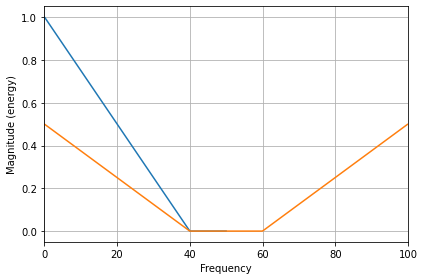

In [100]:
# WRITE YOUR CODE IN THIS CELL:
L = 2

x_l = np.zeros(len(x_n)*L)
x_l[::L] = x_n

print(len(x_l), len(x_n))

plt.magnitude_spectrum(x_n, Fs=fs)
plt.magnitude_spectrum(x_l, Fs=fs*L);

[Here](figures/task1c_lf.png) is a plot showing what the interpolated signal magnitude spectrum should look like. 
* Study the magnitude spectrum, and explain why there is a high-frequency mirror image of the original signal, and why the magnitude of each mirror image is half that of the original.

ANSWER THEORY QUESTIONS HERE:

Because half of the values in the signal are 0, the amplitude gets halved, the energy of the orignal signal gets "spread out". It produces a mirror image because the freqeuency content gets mirrored around the nyqvist frequency of the original signal.

Now let's implement the second stage, where we use a filter to suppress the right half of the frequency spectrum from problem **c)**.

## d)
* Use the lowpass filter from problem **b)** to finish the interpolation process and produce a new upsampled digital signal $x_{\text{new}}[m] = x\left(m\cdot \frac{T_s}{2}\right)$. Show the magnitude spectrum of both the original signal $x[n]$, and the upsampled signal $x_{\text{new}}[m]$.

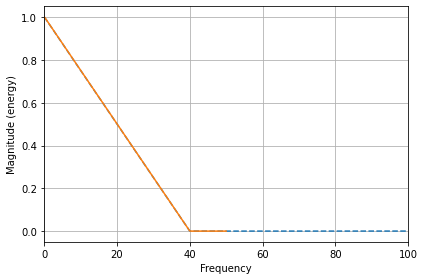

In [101]:
# WRITE YOUR CODE IN THIS CELL:

x_new = np.convolve(x_l,hn, mode="same")*L         #<---------- spør om scaling mtp på filter
plt.magnitude_spectrum(x_new, Fs=fs*L, linestyle="--");
plt.magnitude_spectrum(x_n, Fs=fs);

[Here](figures/task1d_lf.png) is a plot showing what the interpolated signal magnitude spectrum should look like. PS: don't worry too much if the magnitudes don't match exaclty, this is merely a scaling issue. The important part is that the *shape* of the upsampled magnitude spectrum is correct.


* Study the magnitude spectrum plot for $x_{\text{new}}[m]$ and $x[n]$. Explain why our current result would be more desirable as a output of an upsampling operation thant the result in task **c)**.

ANSWER THEORY QUESTIONS HERE:

This output is more desired because the aliasing overlap past original signals nyqvist freqncy is removed.

### Resampling

We have now covered how to decrease sampling frequency by a integer ration $M$, and how to increase sampling frequency by a integer ratio $L$. However, in order to achieve a sample rate conversion by a non-integer ratio we need to combine both upsampling and downsampling. Resampling can be performed as long as the ratio of sampling frequencies is a rational number:
$$\frac{f_{s, \text{ new}}}{f_{s, \text{ old}}} = \frac{L}{M}, \ \ \ L, M \in \mathbb{Z}$$

The signal processing operations which accomplish this resampling can be divided into 3 steps:
1. Interpolate the signal $x_{old}[n]$ by a factor of $L$, interspersing each sample with $L-1$ zeros.
2. Filter the interpolated signal with a lowpass filter which suppresses all frequencies above $f_c = \text{min}\left(\frac{f_{s, \text{ new}}}{2}, \frac{f_{s, \text{ old}}}{2} \right)$, passband gain of $L$
3. Decimate the filtered signal by a factor of $M$


## e)
* Determine what the Nyquist Frequency for the signal $x(t)$ represented by the samples $x[n]$ is. Then, determine what the upsampling factor $L$ and downsampling factor $M$ needs to be for the combined interpolation and decimation system in figure .... to resample the signal at precisely the Nyquist frequency. Finally, determine what the corner frequency $\hat{\omega}_c$ of the lowpass filter used for resampling needs to be for the $-6dB$ cutoff to occur precisely at the Nyquist Frequency.
* Finally, use the your code soution from problems **a)** through **d)** to resample the signal using a newly designed FIR lowpass filter, and plot the magnitude spectrum of the resampled signal. Alternativelym you can use the built-in function  [`upfirdn`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.upfirdn.html).

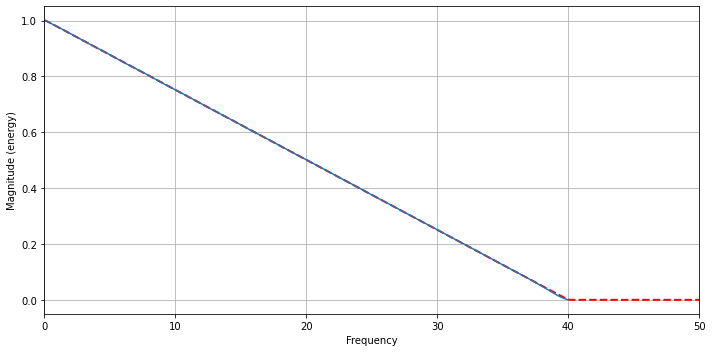

In [102]:
f_nyquist = 40  # Nyquist Frequency
M = 5  # Downsampling factor
L = 4  # Upsampling factor.
w_c = np.pi/5  # -6dB cutoff frequency for resampling filter = min(pi/m, pi/L)

x_l = np.zeros(len(x_n)*L)
x_l[::L] = x_n

hn = w_c/np.pi*np.sinc(w_c/np.pi*n)*sig.windows.hamming(nTaps)
x_l = np.convolve(x_l,hn,mode="same")*L
x_l = x_l[::M]


plt.close(5);plt.figure(5,figsize=(10,5))
plt.magnitude_spectrum(x_n,Fs=fs,linestyle="--",linewidth=2, color="r");
plt.magnitude_spectrum(x_l,Fs=80);

# WRITE YOUR CODE IN THIS CELL:

[Here](figures/task1e_lf.png) is a plot showing what the interpolated signal magnitude spectrum should look like. PS: don't worry too much if the magnitudes don't match exaclty, this is merely a scaling issue. The important part is that the *shape* of the upsampled magnitude spectrum is correct.

In [103]:
from hashlib import sha1
assert sha1(str(round(f_nyquist)).encode('utf-8')+b'e0b5a').hexdigest() == '21c7b924e527a0638233adafe70cac78be3a78be', 'Wrong answer for f_nyquist :('; print('Correct answer for f_nyquist :)')
assert sha1(str(round(M)).encode('utf-8')+b'6d5db').hexdigest() == '15732e35cb2875d2566f11a3ac8184f32990f0be', 'Wrong answer for M :('; print('Correct answer for M :)')
assert sha1(str(round(L)).encode('utf-8')+b'904ad').hexdigest() == 'fb8d8d7db26743e1d048889f053ec9a0d21a3883', 'Wrong answer for L :('; print('Correct answer for L :)')
assert sha1(str(round(w_c, 5)).encode('utf-8')+b'7da52').hexdigest() == '54901accde568e56eae88f9e81a42dc199cd0b31', 'Wrong answer for w_c :('; print('Correct answer for w_c :)')

Correct answer for f_nyquist :)
Correct answer for M :)
Correct answer for L :)


AssertionError: Wrong answer for w_c :(